In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.salfeh = abund[0,0]+np.log10(0.655*(10**(abund[1,0]))+0.345) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.345/(0.655*(10**(abund[1,0]))+0.345))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
        
        mass_idx = []
        self.uniq_masses = np.unique(self.iso['Mass'])
        for i in range(len(self.uniq_masses)):
            masses, = np.where(self.iso['Mass']==self.uniq_masses[i])
            mass_idx.append(np.array([min(masses),max(masses)]))

        self.mass_idx = np.asarray(mass_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        self.rv = rv
       
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav    
        
    def teff_2_appmags(self,teff,age,ak,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
    
    def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_aks = []
        curve_ages_err = []
        curve_aks_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            for k in range(len(guess_aks)):  
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
                                          bounds=((0.,0.),(17.,2.)),method='trf',sigma=self.phot_err,
                                          absolute_sigma=True,maxfev=5000)

                    # populate lists
                    curve_ages.append(popt[0])
                    curve_aks.append(popt[1])
                    curve_ages_err.append(np.sqrt(pcov[0][0]))
                    curve_aks_err.append(np.sqrt(pcov[1][1]))
                    curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
                    curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

                except:
                    #populate lists
                    curve_mags = 999999.0*np.ones(5)
                    curve_ages.append(999999.0)
                    curve_aks.append(999999.0)
                    curve_ages_err.append(999999.0)
                    curve_aks_err.append(999999.0)
                    curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        ak = np.asarray(curve_aks)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        ak_err = np.asarray(curve_aks_err)[idx]

        best_params = np.array([age,ak])
        best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff2appmags(self.teff,age,ak)

        if verbose:
            print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
            print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params, best_params_err
        
    def get_ak(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        akdist = 999999.0*np.ones(nsamples)

        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]

                ### use a spline to get the intrinsic color and calculate the reddening
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print(ccm)
                    print(np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)
                akdist[j] = calc_ak

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)   
                    akdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                    color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                    age_spl_interp = np.poly1d(np.squeeze(
                        np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
                    if verbose:
                        print('interp',age_spl_interp)
                        print('logteff',lgteffdist[j])
                        print('interp age',age_spl_interp(lgteffdist[j]))
                        print('color',self.phot[i]-self.phot[4])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))
                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print('CCM: ',ccm)
                    print('Ak each band',np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)

#                 print(calc_ak)
                akdist[j] = calc_ak
            
#         print(akdist)
        med_calc_ak = np.nanmedian(akdist)
        mad_calc_ak = self.mad(akdist)
        
        if np.isfinite(med_calc_ak)==False:
            med_calc_ak = 999999.0
        if np.isfinite(mad_calc_ak)==False:
            mad_calc_ak = 999999.0
        
        self.ak = med_calc_ak
        self.ak_err = mad_calc_ak
        
        return np.array([med_calc_ak,mad_calc_ak])

    def teff_2_appmags_age(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
        
    def get_age(self,guess_ages=np.arange(0,17),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_ages_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags_age,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,17.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_mags = np.asarray(self.teff_2_appmags_age(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        self.age = age
        age_err = np.asarray(curve_ages_err)[idx]

        best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

        if verbose:
            print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
            print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params
    
    def get_mass(self,verbose=False):
        '''
        Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

        Output:
        ------
        mass_arr: np.array([med_calc_mass,mad_calc_mass]) in Msun, the mass and median absolute deviation
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        massdist = 999999.0*np.ones(nsamples)

        if self.age == 999999.0:
            return np.array([999999.0,999999.0])
        
        lgage = np.log10(self.age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[self.age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('mass: ',999999.0)
                    massdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]
                
                ### Use spline to find mass for a point in lgteffdist
                mass_spl = IUS(slogTe,iso_['Mass'][sidx][uidx])
                massdist[j] = mass_spl(np.log10(lgteffdist[j]))

                if verbose:
                    print('mass',mass_spl(np.log10(lgteffdist[j])))

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('mass: ',999999.0)   
                    massdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('mass: ',999999.0)
                    massdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9

                mass_spl_lo = IUS(slogTe_lo,iso_lo['Mass'][sidx_lo][uidx_lo])
                mass_spl_hi = IUS(slogTe_hi,iso_hi['Mass'][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(
                    np.polyfit([age_lo,age_hi],[mass_spl_lo(lgteffdist[j]),mass_spl_hi(lgteffdist[j])],1)))

                massdist[j] = age_spl_interp(self.age)
            
        med_calc_mass = np.nanmedian(massdist)
        mad_calc_mass = self.mad(massdist)
        
        if np.isfinite(med_calc_mass)==False:
            med_calc_mass = 999999.0
        if np.isfinite(mad_calc_mass)==False:
            mad_calc_mass = 999999.0
        
        self.mass = med_calc_mass
        self.mass_err = mad_calc_mass
        
        mass_arr = np.array([med_calc_mass,mad_calc_mass])
        return mass_arr
    
#     def test(self,x=3.0):
#         print('Hello World!')
    
    def mass_2_age(mass,salfeh,isochrones):
        '''

        Input:
        -----
            mass: mass of star

        Output:
        ------
            age: age of star
        '''
        mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

        iso_lo = isochrones[np.where(self.iso['Mass']==mass_lo)]
        iso_hi = isochrones[np.where(self.iso['Mass']==mass_hi)]

        # younger
        sidx_lo = np.argsort(iso_lo['MH'])
        sMH_lo = iso_lo['MH'][sidx_lo]
        _, uidx_lo = np.unique(sMH_lo,return_index=True)
        sMH_lo = sMH_lo[uidx_lo]

        spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

        # older
        sidx_hi = np.argsort(iso_hi['MH'])
        sMH_hi = iso_hi['MH'][sidx_hi]
        _, uidx_hi = np.unique(sMH_hi,return_index=True)
        sMH_hi = sMH_hi[uidx_hi]

        spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

        # final spline
        final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
        age = final_spl(mass)
        return age
    
    def age_diagnostic(self,best_fit_age,star_name=None,lit_age=None,filename=None,verbose=False):
        '''
        Create a diagnostic plot for the best fit age
        
        Inputs:
        ------
            best_fit_age: best fit age in Gyr
            star_name: name of star
            lit_age: known literature age in Gyr
            filename: name of file if saving plot
        '''
        
        # intialize arrays
        ages = np.arange(0,15,0.25)
        theos_w_ext = 999999.0*np.ones((len(ages),5))
        theos_wo_ext = 999999.0*np.ones((len(ages),5))
        
        # Calculate theoretical mags given an age in ages
        for i in range(len(ages)):
            theos_w_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],self.ak)
            theos_wo_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],0)
            
        # plot results
        fig, ax = plt.subplots(1,5,figsize=[67,15])
        for j in range(5):
            # with extinction
            ax[j].scatter(theos_w_ext[:,j],ages,s=100,label='Best Fit Ak')
            ax[j].plot(theos_w_ext[:,j],ages)
            
            # without extinction
            ax[j].scatter(theos_wo_ext[:,j],ages,s=100,label='No Ak')
            ax[j].plot(theos_wo_ext[:,j],ages)
            
            ax[j].axhline(best_fit_age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
            if lit_age != None:
                ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
            ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
            ax[j].set_xlim(-14,14)
            ax[j].set_ylim(bottom=0.01)
            
            ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
            ax[j].set_xlabel(r'Magnitude')
        
        ax[0].legend()
        
        ax[0].set_ylabel('Age')
        
        if star_name != None:
            plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_age,
                                                                          self.ak,self.distance))
            
        else:
            plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_age,self.ak,
                                                                      self.distance))
            
        if filename != None:
            plt.savefig(filename,bbox_inches='tight')
            
        plt.show()

# Extra Functions

In [2]:
from dlnpyutils import robust

In [3]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# Parsec

In [4]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

<ipython-input-5-ea4b86b12b0d>:28: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


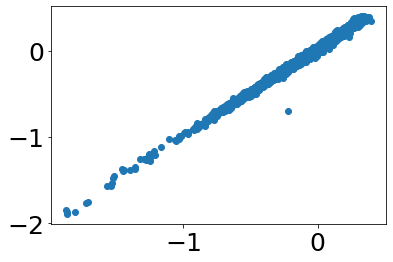

In [5]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

# Gaia Errors

In [6]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

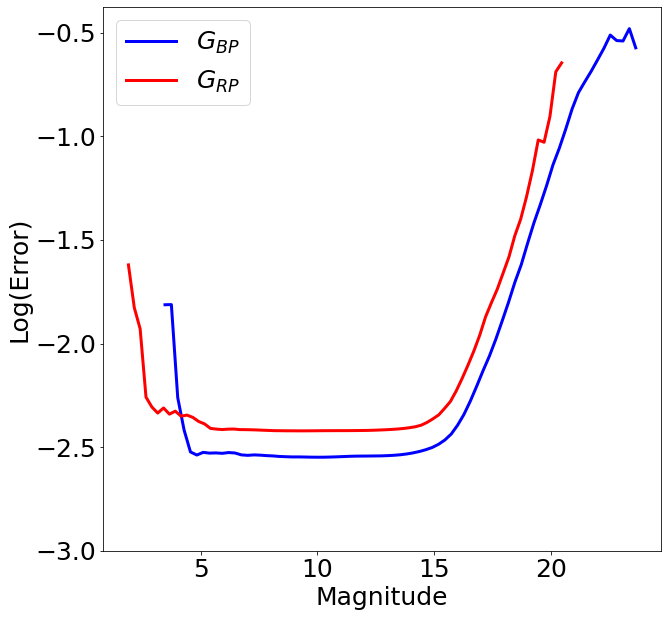

In [7]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

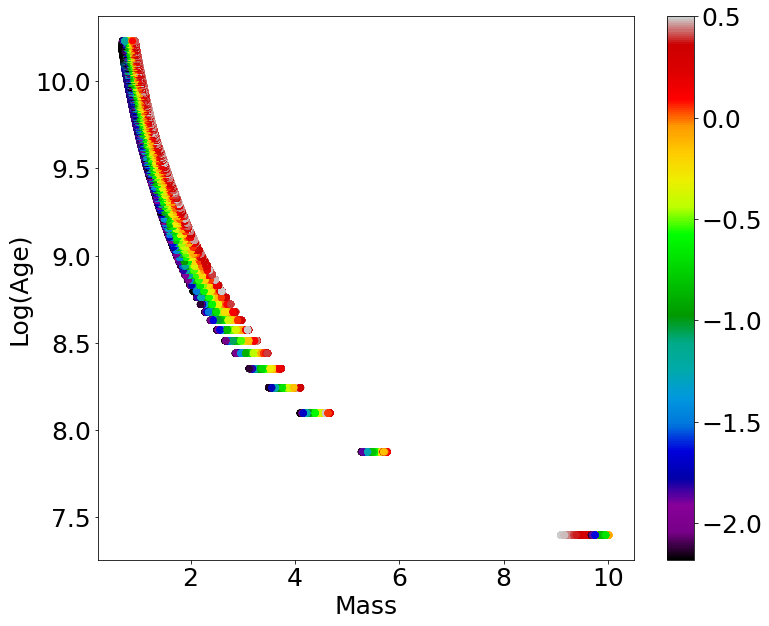

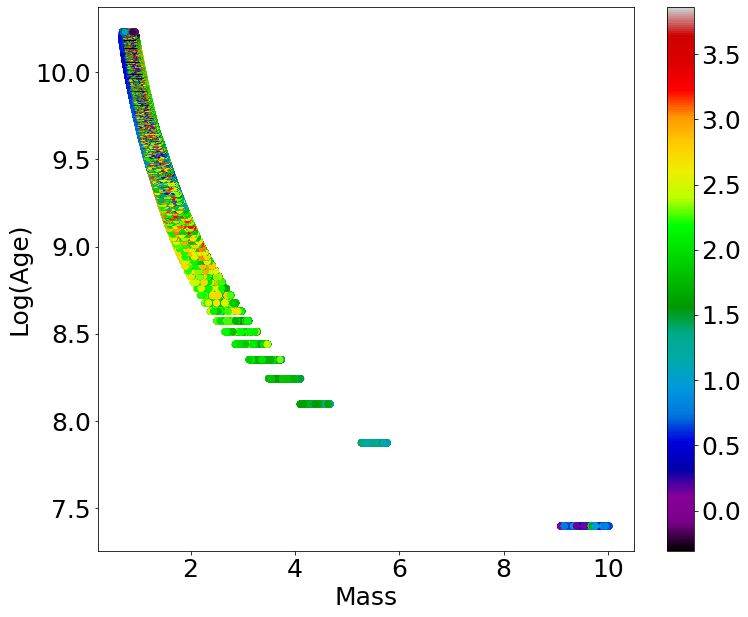

In [8]:
plt.figure(figsize=[12,10])
plt.scatter(massive['Mass'],massive['logAge'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.xlabel(r'Mass')
plt.ylabel(r'Log(Age)')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(massive['Mass'],massive['logAge'],c=massive['logg'],cmap='nipy_spectral')
plt.colorbar()
plt.xlabel(r'Mass')
plt.ylabel(r'Log(Age)')
plt.show()

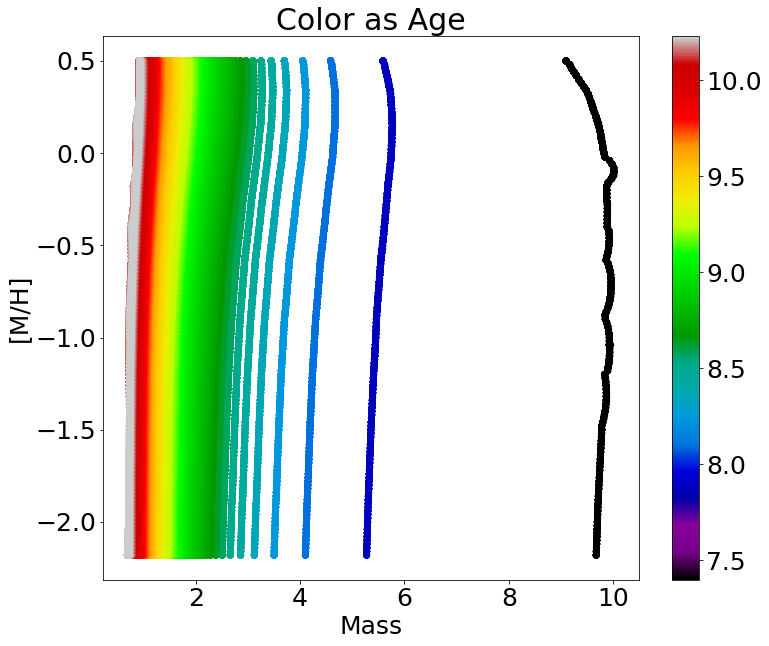

In [9]:
plt.figure(figsize=[12,10])
plt.scatter(massive['Mass'],massive['MH'],c=massive['logAge'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Mass')
plt.ylabel(r'[M/H]')
plt.show()

In [11]:
# sidx = np.argsort(massive[single_mass]['MH'])
# sMH = massive[single_mass]['MH'][sidx]
# _, uidx = np.unique(sMH,return_index=True)
# sMH = sMH[uidx]

# IUS(sMH,massive['logAge'][single_mass][sidx][uidx])

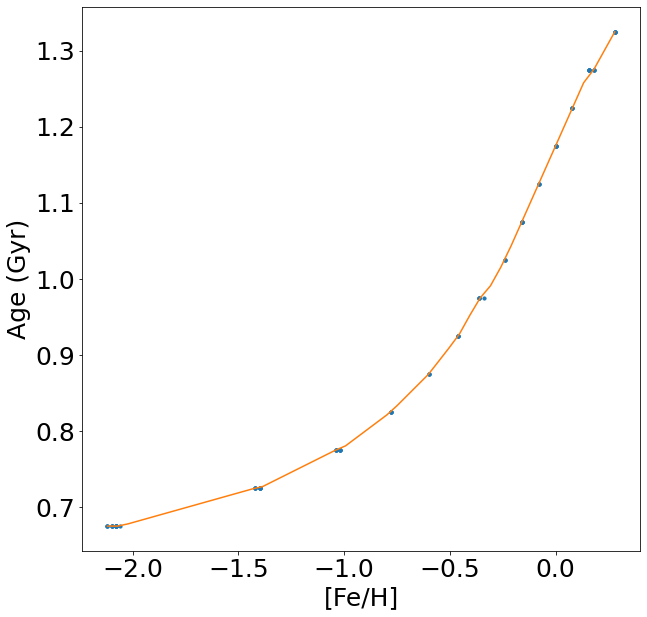

In [12]:
from scipy.interpolate import interp1d

single_mass = np.where(massive['Mass']==closest(massive['Mass'],2.0))

massive[single_mass]['MH']
s = np.argsort(massive[single_mass]['MH'])
spl = interp1d(massive[single_mass]['MH'][s],10**massive[single_mass]['logAge'][s]/10**9)
spl_xs = np.linspace(min(massive[single_mass]['MH'][s]),max(massive[single_mass]['MH'][s]))

sidx = np.argsort(massive[single_mass]['MH'])
sMH = massive[single_mass]['MH'][sidx]
_, uidx = np.unique(sMH,return_index=True)
sMH = sMH[uidx]

spl = IUS(sMH,10**massive['logAge'][single_mass][sidx][uidx]/10**9,k=1)

plt.figure(figsize=[10,10])
plt.plot(spl_xs,spl(spl_xs),c='tab:orange')
plt.scatter(massive[single_mass]['MH'][s],10**massive[single_mass]['logAge'][s]/10**9,s=10)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Age (Gyr)')
plt.show()

<TableColumns names=('KICID','Mass','Logg','Fe/H','Al/Fe','Teff','C/N','M_err','Logg_err','Fe/H_err','Al/Fe_err','Teff_err','2MASSID','IntTeff','IntML','IntAge','IntC12','IntC13','IntN14','IntXsurf')>

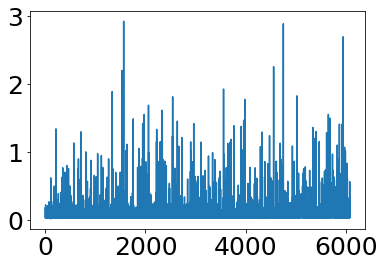

In [13]:
plt.plot(k3dr17['M_err'])

k3dr17.columns

In [14]:
# from scipy.interpolate import splev, splrep

# spl = splrep(massive[single_mass]['MH'][s],10**massive[single_mass]['logAge'][s]/10**9, k=3, s=1000)



In [15]:
# import matplotlib.pyplot as plt
# from scipy.interpolate import splev, splrep
# x = np.linspace(-10, 10, 10)
# y = np.sin(x)
# spl = splrep(x, y)
# x2 = np.linspace(-10, 10, 200)
# # x2=1.5
# y2 = splev(x2, spl)
# plt.plot(x, y, 'o', x2, y2)
# plt.show()

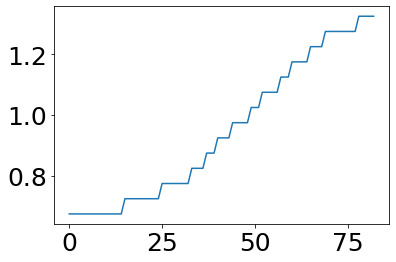

In [16]:
plt.plot(10**massive[single_mass]['logAge'][s]/10**9)

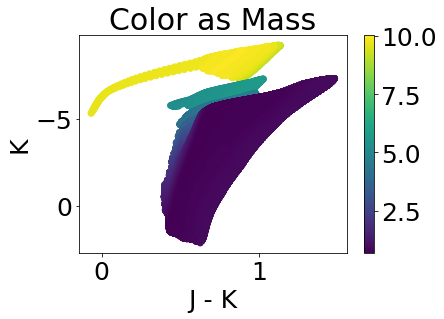

In [17]:
plt.scatter(massive['Jmag']-massive['Ksmag'],massive['Ksmag'],c=massive['Mass'])
plt.colorbar()
plt.gca().invert_yaxis()

plt.title(r'Color as Mass')
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.show()

In [18]:
def mass_2_age(mass,salfeh,isochrones):
    '''

    Input:
    -----
        mass: mass of star

    Output:
    ------
        age: age of star
    '''
    mass_lo,mass_hi = neighbors(massive['Mass'],mass)

    iso_lo = massive[np.where(massive['Mass']==mass_lo)]
    iso_hi = massive[np.where(massive['Mass']==mass_hi)]

    # younger
    sidx_lo = np.argsort(iso_lo['MH'])
    sMH_lo = iso_lo['MH'][sidx_lo]
    _, uidx_lo = np.unique(sMH_lo,return_index=True)
    sMH_lo = sMH_lo[uidx_lo]

    spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

    # older
    sidx_hi = np.argsort(iso_hi['MH'])
    sMH_hi = iso_hi['MH'][sidx_hi]
    _, uidx_hi = np.unique(sMH_hi,return_index=True)
    sMH_hi = sMH_hi[uidx_hi]

    spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

    # final spline
    final_spl = interp1d([mass_lo,mass_hi],[spl_lo(salfeh),spl_hi(salfeh)])
    age = final_spl(mass)
    return age


# younger
# sidx_lo = np.argsort(iso_lo['logTe'])
# slogTe_lo = iso_lo['logTe'][sidx_lo]
# _, uidx_lo = np.unique(slogTe_lo,return_index=True)
# slogTe_lo = slogTe_lo[uidx_lo]

# # older
# sidx_hi = np.argsort(iso_hi['logTe'])
# slogTe_hi = iso_hi['logTe'][sidx_hi]
# _, uidx_hi = np.unique(slogTe_hi,return_index=True)
# slogTe_hi = slogTe_hi[uidx_hi]

# ### use a spline to get the apparent mags
# age_lo = 10**lgage_lo/10**9
# age_hi = 10**lgage_hi/10**9
# calc_mags = 999999.0*np.ones(5)
# calc_mags0 = 999999.0*np.ones(5)
# for i in range(5):
#     mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#     mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#     age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                      [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#     calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
#     calc_mags0[i] = age_spl_interp(age)+self.distmod

# if verbose:
#     print('[BP,RP,J,H,K]: ',calc_mags)
#     print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
# return calc_mags
    
    
#     # younger
#     sidx_lo = np.argsort(iso_lo['MH'])
#     sMH_lo = iso_lo['MH'][sidx_lo]
#     _, uidx_lo = np.unique(sMH_lo,return_index=True)
#     sMH_lo = sMH_lo[uidx_lo]

#     # older
#     sidx_hi = np.argsort(iso_hi['MH'])
#     sMH_hi = iso_hi['MH'][sidx_hi]
#     _, uidx_hi = np.unique(sMH_hi,return_index=True)
#     sMH_hi = sMH_hi[uidx_hi]

#     ### use splines to get age between two masses and get final age
#     spl_lo = IUS(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9,k=1)
#     spl_hi = IUS(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9,k=1)

#     final_spl = IUS([mass_lo,mass_hi],[spl_lo(mass_lo),spl_hi(mass_hi)],k=1)
#     age = final_spl(mass)
#     return age
    
# massive[single_mass]['MH']
# s = np.argsort(massive[single_mass]['MH'])
# spl = interp1d(massive[single_mass]['MH'][s],10**massive[single_mass]['logAge'][s]/10**9)
# spl_xs = np.linspace(min(massive[single_mass]['MH'][s]),max(massive[single_mass]['MH'][s]))

# sidx = np.argsort(massive[single_mass]['MH'])
# sMH = massive[single_mass]['MH'][sidx]
# _, uidx = np.unique(sMH,return_index=True)
# sMH = sMH[uidx]

# spl = IUS(sMH,10**massive['logAge'][single_mass][sidx][uidx]/10**9,k=1)

# Calculate Ages

In [19]:
from tqdm import tqdm_notebook

# kasc_ak = 999999.0*np.ones(len(np.squeeze(ageevs)))
# kasc_ak_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age2 = 999999.0*np.ones(len(np.squeeze(ageevs)))
# kasc_age_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
# kasc_mass = 999999.0*np.ones(len(np.squeeze(ageevs)))
# kasc_mass_err = 999999.0*np.ones(len(np.squeeze(ageevs)))

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    te = np.array([kdr17[i],kdr17['TEFF_ERR'][i]])
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    try:
        kasc_age2[i] = CalcAge.mass_2_age(k3dr17['Mass'][i])
    except:
        kasc_age2[i] = 999999.0

<ipython-input-19-7ea1304c987d>:11: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)
<ipython-input-19-7ea1304c987d>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


<ipython-input-19-7ea1304c987d>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  te = np.array([kdr17[i],kdr17['TEFF_ERR'][i]])


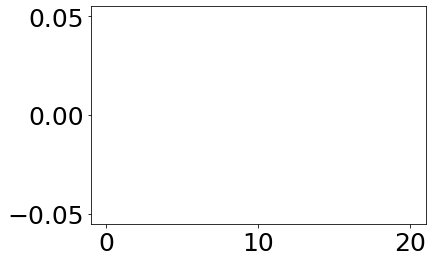

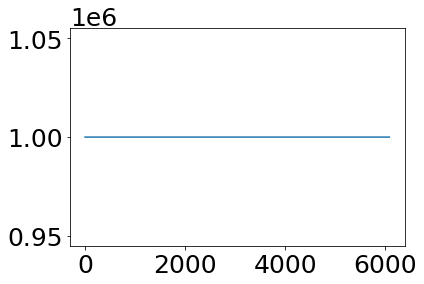

In [20]:
plt.hist(kasc_age2,range=(0,20))
plt.show()

# plt.figure(figsize=[20,7])
plt.plot(kasc_age2)
# plt.ylim(0,20)

In [21]:
plt.figure(figsize=[10,10])
plt.scatter(k3dr17['IntAge'],kasc_age,s=10)
plt.ylim(0,20)
plt.xlim(0,20)
plt.plot([0,20],[0,20],c='k')

plt.xticks([0.0,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0])
plt.yticks([0.0,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0])
plt.grid()

plt.xlabel('APOKASC 3 Age')
plt.ylabel(r'PARSEC Age')
plt.savefig('../plots/pkasc_age2age.pdf',dpi=300,bbox_inches='tight')
plt.show()

NameError: name 'kasc_age' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
pkasc_colors = np.array([kdr17['FE_H'],apoafe,kdr17['TEFF'],kdr17['LOGG'],kdr17['K'],k3dr17['Mass']])
pkasc_titles = np.array(['[Fe/H]','[$\\alpha$/Fe]','Teff','Log(g)','K','Mass'])
pkasc_saves = np.array(['feh','afe','teff','logg','kmag','mass'])

for i in range(len(pkasc_colors)):

    plt.figure(figsize=[12,10])
    plt.scatter(k3dr17['IntAge'],kasc_age,s=10,c=pkasc_colors[i],cmap='nipy_spectral')
    plt.colorbar()
    plt.ylim(0,20)
    plt.xlim(0,20)
    plt.plot([0,20],[0,20],c='k')

    plt.xticks([0.0,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0])
    plt.yticks([0.0,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0])
    plt.grid()

    plt.title(r'Color as {}'.format(pkasc_titles[i]))
    plt.xlabel('APOKASC 3 Age')
    plt.ylabel(r'PARSEC Age')
    plt.savefig('../plots/parsec_apokasc_age{}.pdf'.format(pkasc_saves[i]),dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(kdr17['FE_H'],kasc_age,s=10)
plt.ylim(0,20)
plt.xlim(-2.0,0.5)
# plt.plot([0,20],[0,20],c='k')

plt.xticks([-2.0,-1.5,-1.0,-0.5,0.0,0.5])
plt.yticks([0.0,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0])
plt.grid()

plt.xlabel('[Fe/H]')
plt.ylabel(r'PARSEC APOKASC Age')
plt.show()

In [ ]:
from tqdm import tqdm_notebook

kasc_age2 = 999999.0*np.ones(len(np.squeeze(ageevs)))

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    te = np.array([kdr17[i],kdr17['TEFF_ERR'][i]])
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    try:
        kasc_age2[i] = CalcAge.mass_2_age(k3dr17['Mass'][i]) #mass_2_age(k3dr17['Mass'][i],CalcAge.salfeh,massive)
    except:
        kasc_age2[i] = 999999.0

In [ ]:
plt.hist(kasc_age2,range=(0,20))
plt.show()

plt.figure(figsize=[20,7])
plt.plot(kasc_age2)
plt.ylim(0,20)

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(k3dr17['IntAge'],kasc_age2,s=10)
plt.ylim(0,20)
plt.xlim(0,20)
plt.plot([0,20],[0,20],c='k')

plt.xticks([0.0,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0])
plt.yticks([0.0,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0])
plt.grid()

plt.xlabel('APOKASC 3 Age')
plt.ylabel(r'PARSEC Age')
# plt.savefig('../plots/pkasc_age2age.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# i=13
# # for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
# te = np.array([kdr17[i],kdr17['TEFF_ERR'][i]])
# ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
#                [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
# op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
#                 kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
#                 kdr17['J'][i],kdr17['H'][i],
#                 kdr17['K'][i]],
#                [bperr[i],rperr[i],kdr17['J_ERR'][i],
#                 kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
# di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

# CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
# print(k3dr17['Mass'][i])
# print(CalcAge.salfeh)

# kasc_age[i] = CalcAge.mass_2_age(k3dr17['Mass'][i])

In [ ]:
single_mass = np.where(massive['Mass']==closest(massive['Mass'],1.90048))
prob_star = massive[single_mass]

In [ ]:
lo,hi = neighbors(massive['Mass'],1.90048)

smass_lo = massive[np.where(massive['Mass']==lo)]
small_hi = massive[np.where(massive['Mass']==hi)]

min(smass_lo['MH'])

In [ ]:
k3dr17['Mass'][13]

In [ ]:
0.03929445565628607<min(prob_star['MH'])

In [ ]:
mass_lo,mass_hi = self.neighbors(self.uniq_masses,mass)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

### Pick out single isochrones

# younger
midx_lo, = np.where(self.uniq_masses==mass_lo)
iso_lo = self.iso[self.mass_idx[int(midx_lo)][0]:self.mass_idx[int(midx_lo)][1]]

# older
midx_hi, = np.where(self.uniq_masses==mass_hi)
iso_hi = self.iso[self.mass_idx[int(midx_hi)][0]:self.mass_idx[int(midx_hi)][1]]

#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])

### [Fe/H] Check
if self.salfeh < min(iso_lo['MH']) or self.salfeh > max(iso_lo['MH']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
    return 999999.0
if self.salfeh < min(iso_hi['MH']) or self.salfeh > max(iso_hi['MH']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
    return 999999.0

### sort so temp is always increasing

# younger
sidx_lo = np.argsort(iso_lo['MH'])
sMH_lo = iso_lo['MH'][sidx_lo]
_, uidx_lo = np.unique(sMH_lo,return_index=True)
sMH_lo = sMH_lo[uidx_lo]

# older
sidx_hi = np.argsort(iso_hi['MH'])
sMH_hi = iso_hi['MH'][sidx_hi]
_, uidx_hi = np.unique(sMH_hi,return_index=True)
sMH_hi = sMH_hi[uidx_hi]

### use splines to get age between two masses and get final age
spl_lo = IUS(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9,k=1)
spl_hi = IUS(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9,k=1)

final_spl = IUS([mass_lo,mass_hi],[spl_lo(mass_lo),spl_hi(mass_hi)],k=1)
age = final_spl(mass)
return age